In [29]:
%matplotlib inline
from matplotlib import style, colors
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd

In [31]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [35]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [36]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

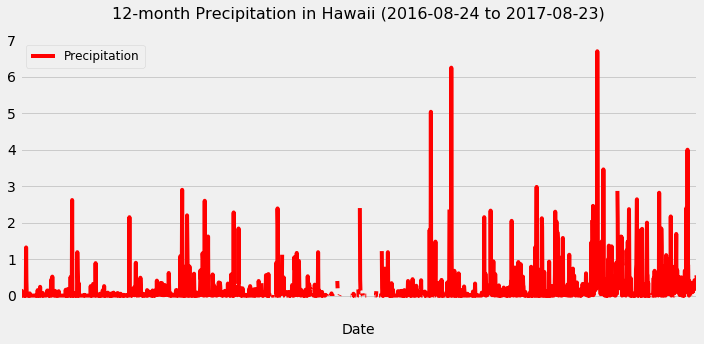

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date of the last data point in the database
last_measurement_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.datetime.strptime(last_measurement_date[0],'%Y-%m-%d').date() - dt.timedelta(weeks=52)

# Perform a query to retrieve the date and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).filter(Measurement.date <= last_measurement_date[0])

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_df = pd.DataFrame(prcp_scores, columns=['Date','Precipitation'])
prcp_scores_df.set_index('Date', inplace=True)

# Drop all rows thave NaN/blank values in the precipitation column 
prcp_scores_df['Precipitation'].dropna(inplace=True)

# Sort the dataframe by date
prcp_scores_df.sort_index(axis=0)

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_scores_df.plot(figsize=(10,5), color='red')
ax.set_title(f'12-month Precipitation in Hawaii ({date_year_ago} to {last_measurement_date[0]})', fontsize=16, pad=20)
ax.set_xlabel('Date', fontsize=14, labelpad=15)
ax.legend(loc='best', fontsize=12)
plt.xticks([])
plt.tight_layout()
plt.savefig(f'images/Yearly_HI_Prcp_{date_year_ago}_{last_measurement_date[0]}.png', dpi=200)
plt.show()

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_scores_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [40]:
# Query to show how many stations are available in this dataset?

session.query(Station).count()

9

In [41]:
# Query to list the most active stations (i.e. stations that have the most rows)
# List the stations and the counts in descending order.

active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

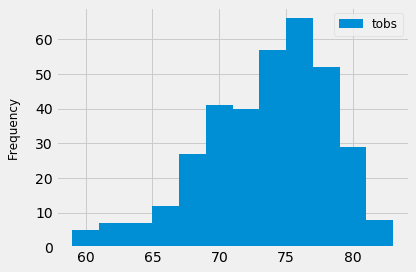

In [43]:
# Query the last 12 months of temperature observation data for the station with the highest number of temperature observations
temp_obs = session.query(Measurement.tobs).filter(Measurement.station == active_stations[0][0]).filter(Measurement.date >= date_year_ago).filter(Measurement.date <= last_measurement_date[0]).all()

# Unpack tuple using list comprehensions
temps = [temp[0] for temp in temp_obs]

# Plot the results as a histogram
fig, ax = plt.subplots(tight_layout=True)
ax.hist(temps[::-1], bins=12)
ax.set_ylabel('Frequency', fontsize=12, labelpad=15)
ax.legend(['tobs'], loc='upper right', fontsize=12)
plt.savefig(f'images/Yearly_HI_Tobs_Station_{active_stations[0][0]}_{date_year_ago}_{last_measurement_date[0]}.png', dpi=200)
plt.show()

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [49]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [50]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [51]:
# Plot the daily normals as an area plot with `stacked=False`
